# Preferential Bayesian Optimization: Dueling-Thompson Sampling

Implementation of the algorithm by Gonzalez et al (2017).

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sphviewer as sph
import sys
import os
import datetime

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 2 levels up directory to import PBO
import PBO

In [2]:
def log(message):
    print(str(datetime.datetime.now()) + ': ' + message)

In [3]:
def plot_gp(model, X, y, title="GP"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

In [4]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)


def forrester_get_y(x):
    """
    :param x: tensor of shape (..., N, 2)
    :return: tensor of shape (..., N, 1)
    """
    forrester_vals = forrester(x)
    return np.expand_dims(forrester_vals[..., 0] < forrester_vals[..., 1], axis=-1).astype(int)

Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

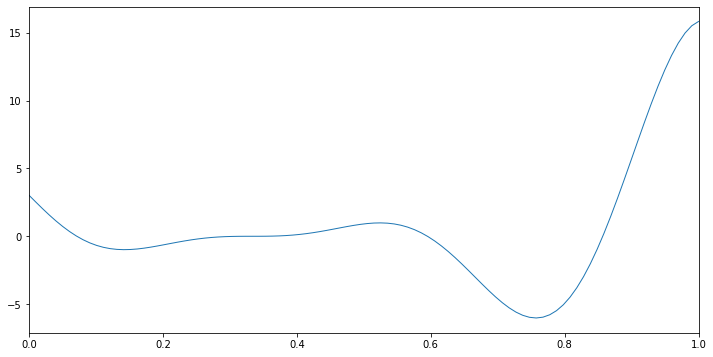

In [5]:
xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6))
plt.plot(xx, forrester(xx), 'C0', linewidth=1)
plt.xlim(-0.0, 1.0)

Create the initial values for each run:

In [6]:
num_runs = 20
num_evals = 20
num_samples = 100
num_choices = 2
input_dims = 1
num_maximizers = 20
num_init_points = 5
num_inducing_init = 5
num_discrete_points = 1000 # Discretization of continuous input space

In [7]:
np.random.seed(0)
init_points = np.random.uniform(size=[num_runs, num_init_points, input_dims])
num_combs = int((num_init_points-1) * num_init_points / 2)
init_vals = np.zeros([num_runs, num_combs, num_choices, input_dims])
for run in range(num_runs):
    cur_idx = 0
    for init_point in range(num_init_points-1):
        for next_point in range(init_point+1, num_init_points):
            init_vals[run, cur_idx, 0] = init_points[run, init_point]
            init_vals[run, cur_idx, 1] = init_points[run, next_point]
            cur_idx += 1

init_vals = np.squeeze(init_vals)  # in this formulation, inputs are 2-D
symmetric_vals = np.flip(init_vals, axis=-1)
init_vals = np.concatenate([init_vals, symmetric_vals], axis=-2)  # Model always has info about symmetric points

In [8]:
def combinations(points):
    """
    :param points: tensor of shape (n, d)
    :return: tensor of shape (n*n, d*2)
    """
    n = points.shape[0]
    d = points.shape[1]

    out = np.zeros((n*n, d*2))
    for i in range(n):
        for j in range(n):
            out[i*n+j][0:d] = points[i]
            out[i*n+j][d:d*2] = points[j]
    return out

In [9]:
def logistic(x):
    return (1/(1+tf.math.exp(-x)))

In [10]:
def logistic_square(x):
    return tf.math.square(logistic(x))

In [11]:
def variance_integral(means, variances):
    return gpflow.quadrature.mvnquad(logistic_square, means, variances, H=50, Din=1)

In [12]:
def expected_integral(means, variances):
    return gpflow.quadrature.mvnquad(logistic, means, variances, H=50, Din=1)

In [13]:
def variance_logistic_f(m, x):
    means, variances = m.predict_f(x)
    variances = tf.expand_dims(variances, axis=1)
    expected_logistic_squared = tf.math.square(expected_integral(means, variances))
    return variance_integral(means, variances)-expected_logistic_squared

In [14]:
side = np.linspace(0.3,0.8,6)
query_points = combinations(np.expand_dims(side, axis=-1))

In [15]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [16]:
mu = [0.5, 0.5]
cov = [[ 0.1, 0],
       [ 0, 0.1]]
mvn = tfd.MultivariateNormalFullCovariance(
    loc=mu,
    covariance_matrix=cov)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [17]:
mvn.prob(query_points)

<tf.Tensor: shape=(36,), dtype=float32, numpy=
array([1.0668474, 1.2395002, 1.3030505, 1.2395002, 1.0668474, 0.8308616,
       1.2395002, 1.4400936, 1.5139288, 1.4400936, 1.2395002, 0.9653236,
       1.3030505, 1.5139288, 1.5915495, 1.5139288, 1.3030505, 1.0148166,
       1.2395002, 1.4400936, 1.5139288, 1.4400936, 1.2395002, 0.9653236,
       1.0668474, 1.2395002, 1.3030505, 1.2395002, 1.0668474, 0.8308616,
       0.8308616, 0.9653236, 1.0148166, 0.9653236, 0.8308616, 0.6470757],
      dtype=float32)>

In [18]:
fake_y = np.expand_dims(mvn.prob(query_points), axis=-1)

In [19]:
fake_y.astype(np.float64)

array([[1.06684744],
       [1.23950016],
       [1.30305052],
       [1.23950016],
       [1.06684744],
       [0.83086163],
       [1.23950016],
       [1.44009364],
       [1.51392877],
       [1.44009364],
       [1.23950016],
       [0.96532363],
       [1.30305052],
       [1.51392877],
       [1.59154952],
       [1.51392877],
       [1.30305052],
       [1.01481664],
       [1.23950016],
       [1.44009364],
       [1.51392877],
       [1.44009364],
       [1.23950016],
       [0.96532363],
       [1.06684744],
       [1.23950016],
       [1.30305052],
       [1.23950016],
       [1.06684744],
       [0.83086163],
       [0.83086163],
       [0.96532363],
       [1.01481664],
       [0.96532363],
       [0.83086163],
       [0.64707571]])

In [20]:
m = gpflow.models.VGP(data=(query_points, forrester_get_y(query_points)),
                      kernel=gpflow.kernels.RBF(),
                      likelihood=gpflow.likelihoods.Bernoulli())
m.kernel.lengthscale.assign(0.1)

m = gpflow.models.VGP(data=(query_points, fake_y),
                      kernel=gpflow.kernels.RBF(),
                      likelihood=gpflow.likelihoods.Gaussian())
m.kernel.lengthscale.assign(0.1)

In [21]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.1000000014901161
VGP.q_mu,Parameter,,,True,"(36, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 36, 36)",float64,"[[[1., 0., 0...."


In [22]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -m.log_likelihood(), m.trainable_variables)

      fun: 16.35904077440788
 hess_inv: <704x704 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.90473022e-05, -1.25259719e-05, -1.42361975e-04, -1.28734973e-04,
       -8.01855714e-05,  9.34703740e-06, -1.45205434e-06, -7.49648698e-06,
       -2.40615654e-05, -1.59201271e-04, -9.11412729e-05, -9.83951953e-05,
       -7.76453283e-05, -3.16281948e-05,  3.29592978e-05, -5.80970833e-05,
        5.32921217e-07, -1.92597770e-05, -2.97855341e-05, -2.27710270e-05,
        7.19441801e-05,  3.96068000e-05, -1.54003144e-05, -7.42494638e-06,
       -9.99289347e-06, -1.28527428e-05,  7.92177808e-05,  7.01973634e-05,
       -1.26581386e-05, -2.08476210e-05, -1.26827742e-05, -1.64540318e-05,
        3.51761463e-05,  3.60275303e-05,  4.10516799e-06,  1.02027036e-06,
       -3.46690086e-06, -1.33756501e-05, -1.56887646e-05,  2.37655834e-05,
       -9.65957924e-07, -1.92427126e-06, -4.17212780e-06, -1.41141609e-06,
        1.29894240e-05,  5.15259826e-06, -1.48506187e-05, -8.20812239e-06,


In [23]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,20.41569994330888
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.16846795591400823
VGP.q_mu,Parameter,,,True,"(36, 1)",float64,[[-0.43404005...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 36, 36)",float64,"[[[3.47009830e-01, 0.00000000e+00, 0.00000000e+00..."


In [24]:
def visualize_model(query_points, m, cmap="Spectral", maximizers=None):

    forrester_get_y(query_points)
    y_vals = np.squeeze(forrester_get_y(query_points), axis=-1)
    pos_vals = []
    neg_vals = []
    for i in range(len(y_vals)):
        if y_vals[i]:
            pos_vals.append(query_points[i])
        else:
            neg_vals.append(query_points[i])
    pos_vals = np.array(pos_vals)
    neg_vals = np.array(neg_vals)

    side = np.linspace(0,1,num_discrete_points)
    X,Y = np.meshgrid(side,side)
    combs = combinations(np.expand_dims(side, axis=1))
    preds = tf.transpose(tf.reshape(m.predict_y(combs)[0], [num_discrete_points, num_discrete_points]))
    variances = tf.transpose(tf.reshape(variance_logistic_f(m, combs), [num_discrete_points, num_discrete_points]))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Mean and variance of model')
    fig.set_size_inches(18.5, 6.88)
    fig.set_dpi((200))
    
    ax1.axis('equal')
    if len(pos_vals) != 0:
        ax1.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax1.scatter(*neg_vals.T, c="black", marker="x")
    if maximizers is not None:
        ax1.scatter(*maximizers.T, c="white")
    im1 = ax1.imshow(preds, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax1.set_title("Mean of y(x, x')")
    ax1.set_xlabel("x")
    ax1.set_ylabel("x'")
    ax1.axvline(x=0.757, linestyle='--')
    fig.colorbar(im1, ax=ax1)

    ax2.axis('equal')
    if len(pos_vals) != 0:
        ax2.scatter(*pos_vals.T, c="black", marker="o")
    if len(neg_vals) != 0:
        ax2.scatter(*neg_vals.T, c="black", marker="x")
    im2 = ax2.imshow(variances, interpolation='nearest', extent=(0.0, 1.0, 0.0, 1.0), origin='lower', cmap=cmap)
    ax2.set_title("Variance of y(x, x')")
    ax2.set_xlabel("x")
    ax2.set_ylabel("x'")
    fig.colorbar(im2, ax=ax2)

    plt.show()

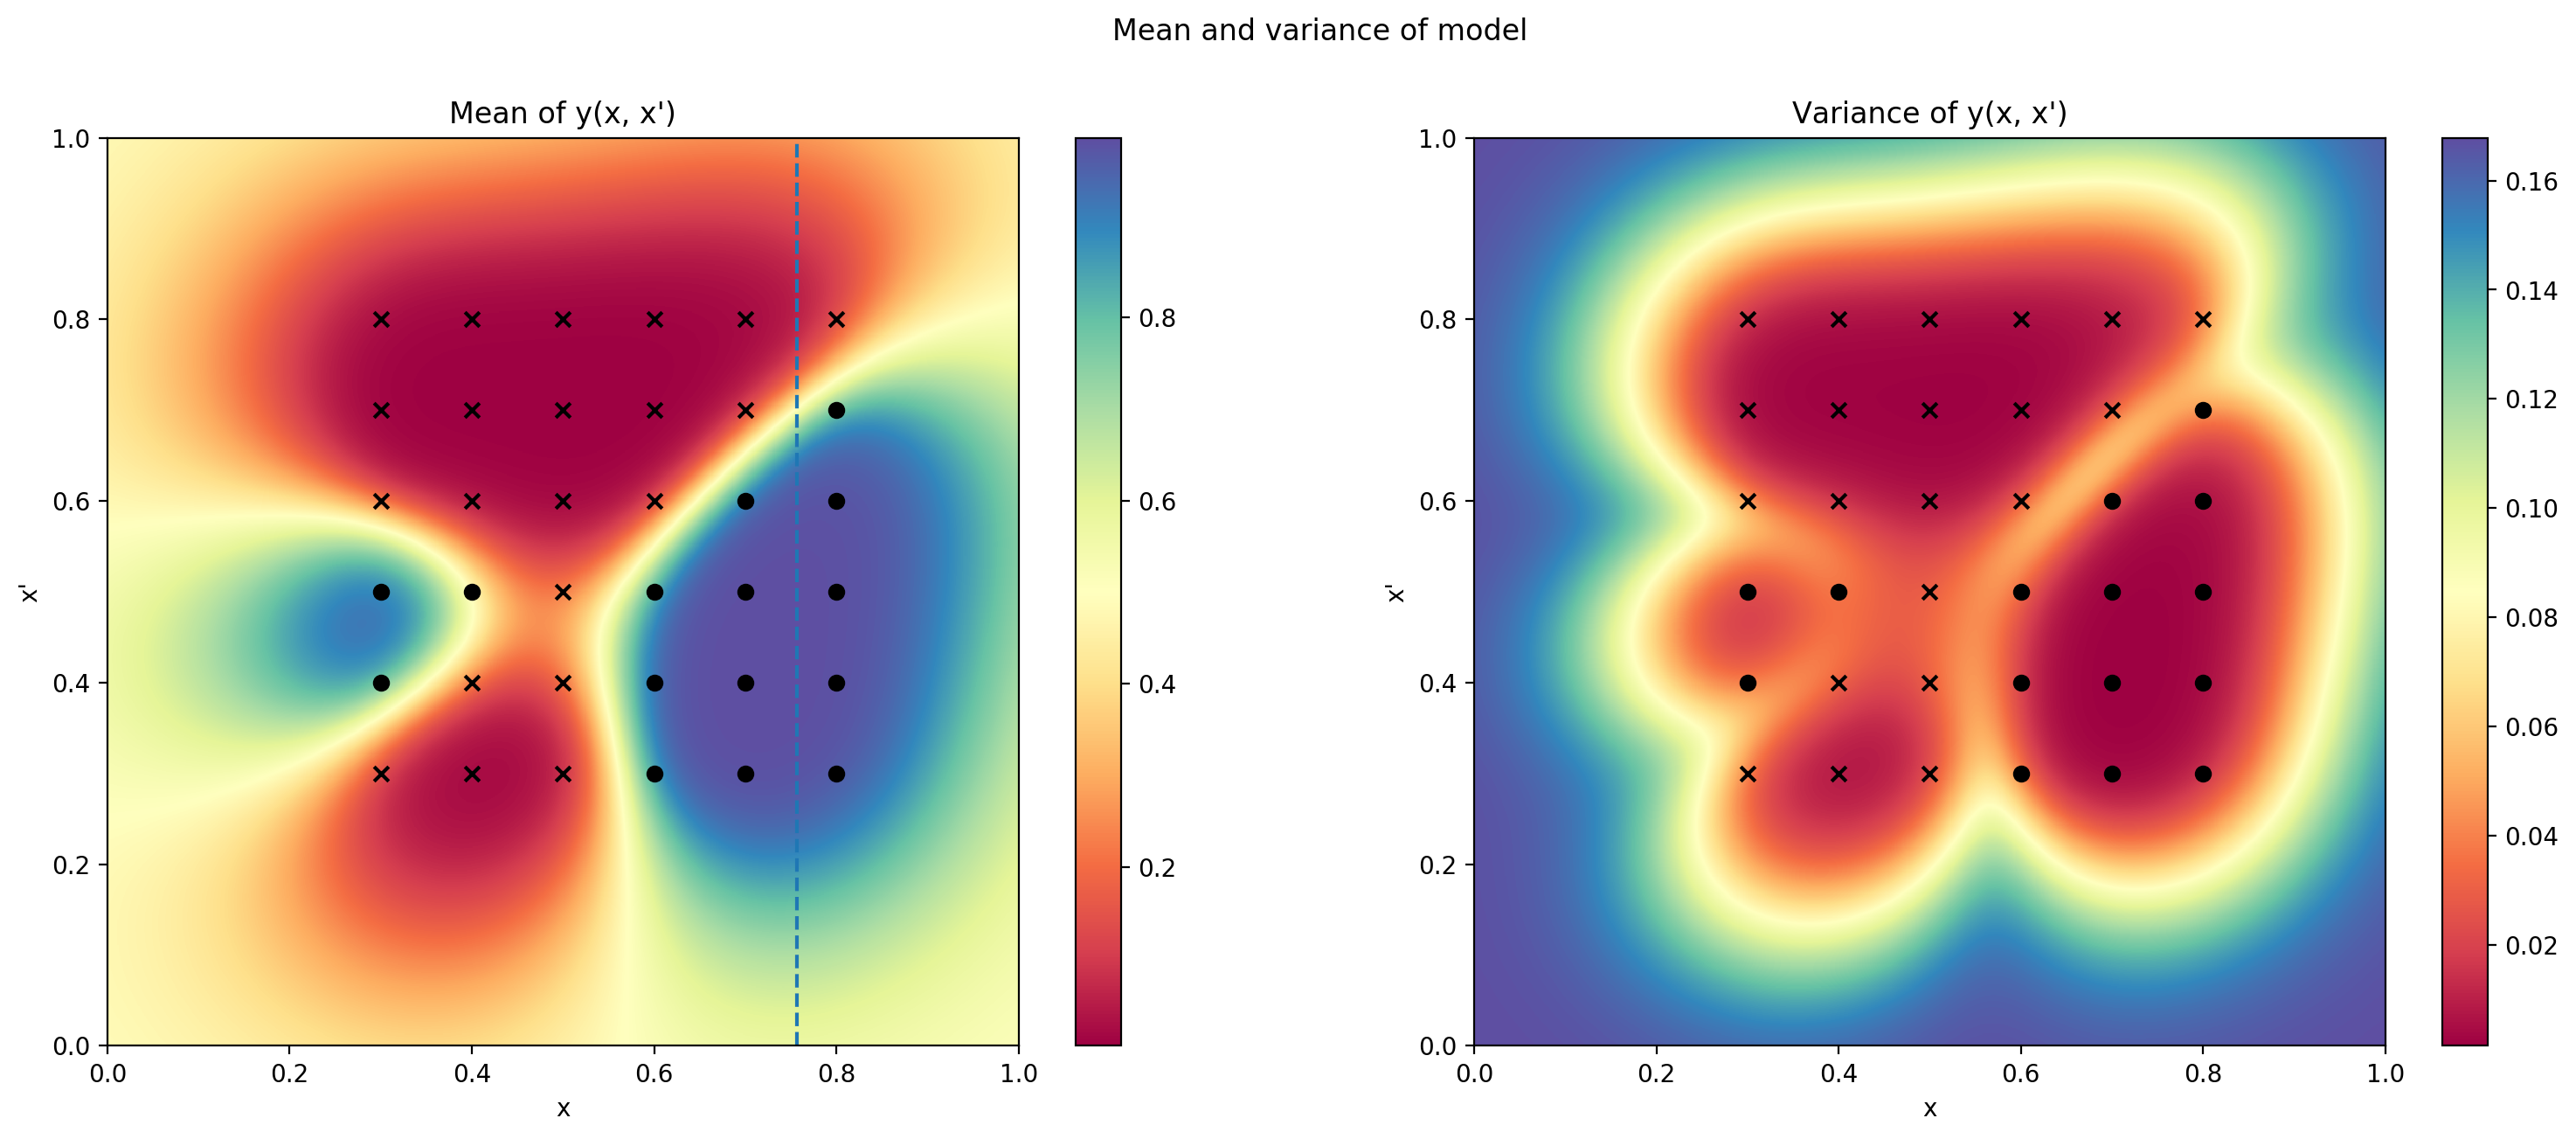

In [25]:
visualize_model(query_points, m)

In [26]:
m.likelihood = gpflow.likelihoods.Gaussian()
maxs = PBO.acquisitions.pes.sample_maximizers(X=query_points,
                  y=m.q_mu,
                  count=1000,
                  D=100,
                  model=m,
                  num_steps=30000)
m.likelihood = gpflow.likelihoods.Bernoulli()

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Loss at step 0: 13.12556896331374
Loss at step 500: -632.8323529529232
Loss at step 1000: -1154.6090051327785
Loss at step 1500: -1490.0146263240247
Loss at step 2000: -1699.5208465660903
Loss at step 2500: -1841.1405702312497
Loss at step 3000: -1940.1639326703578
Loss at step 3500: -2010.8273733336646
Loss at step 4000: -2064.134341204986
Loss at step 4500: -2102.1695050935127
Loss at step 5000: -2131.308167287594
Loss at step 5500: -2157.2714525241445
Loss at step 6000: -2176.678306163972
Loss at step 6500: -2190.6965301085593
Loss at step 7000: -2201.550117338858
Loss at step 7500: -2209.7179447894173
Loss at step 8000: -2217.0445268557596
Loss at step 8500: -2222.5249705207943
Loss at step 9000: -2226.7515790834423
Loss at step 9500: -2230.10074935392
Loss at step 10000: -2232.7886469345062
Loss at step 10500: -2234.965318343956
Loss at step 11000: -2236.720369375

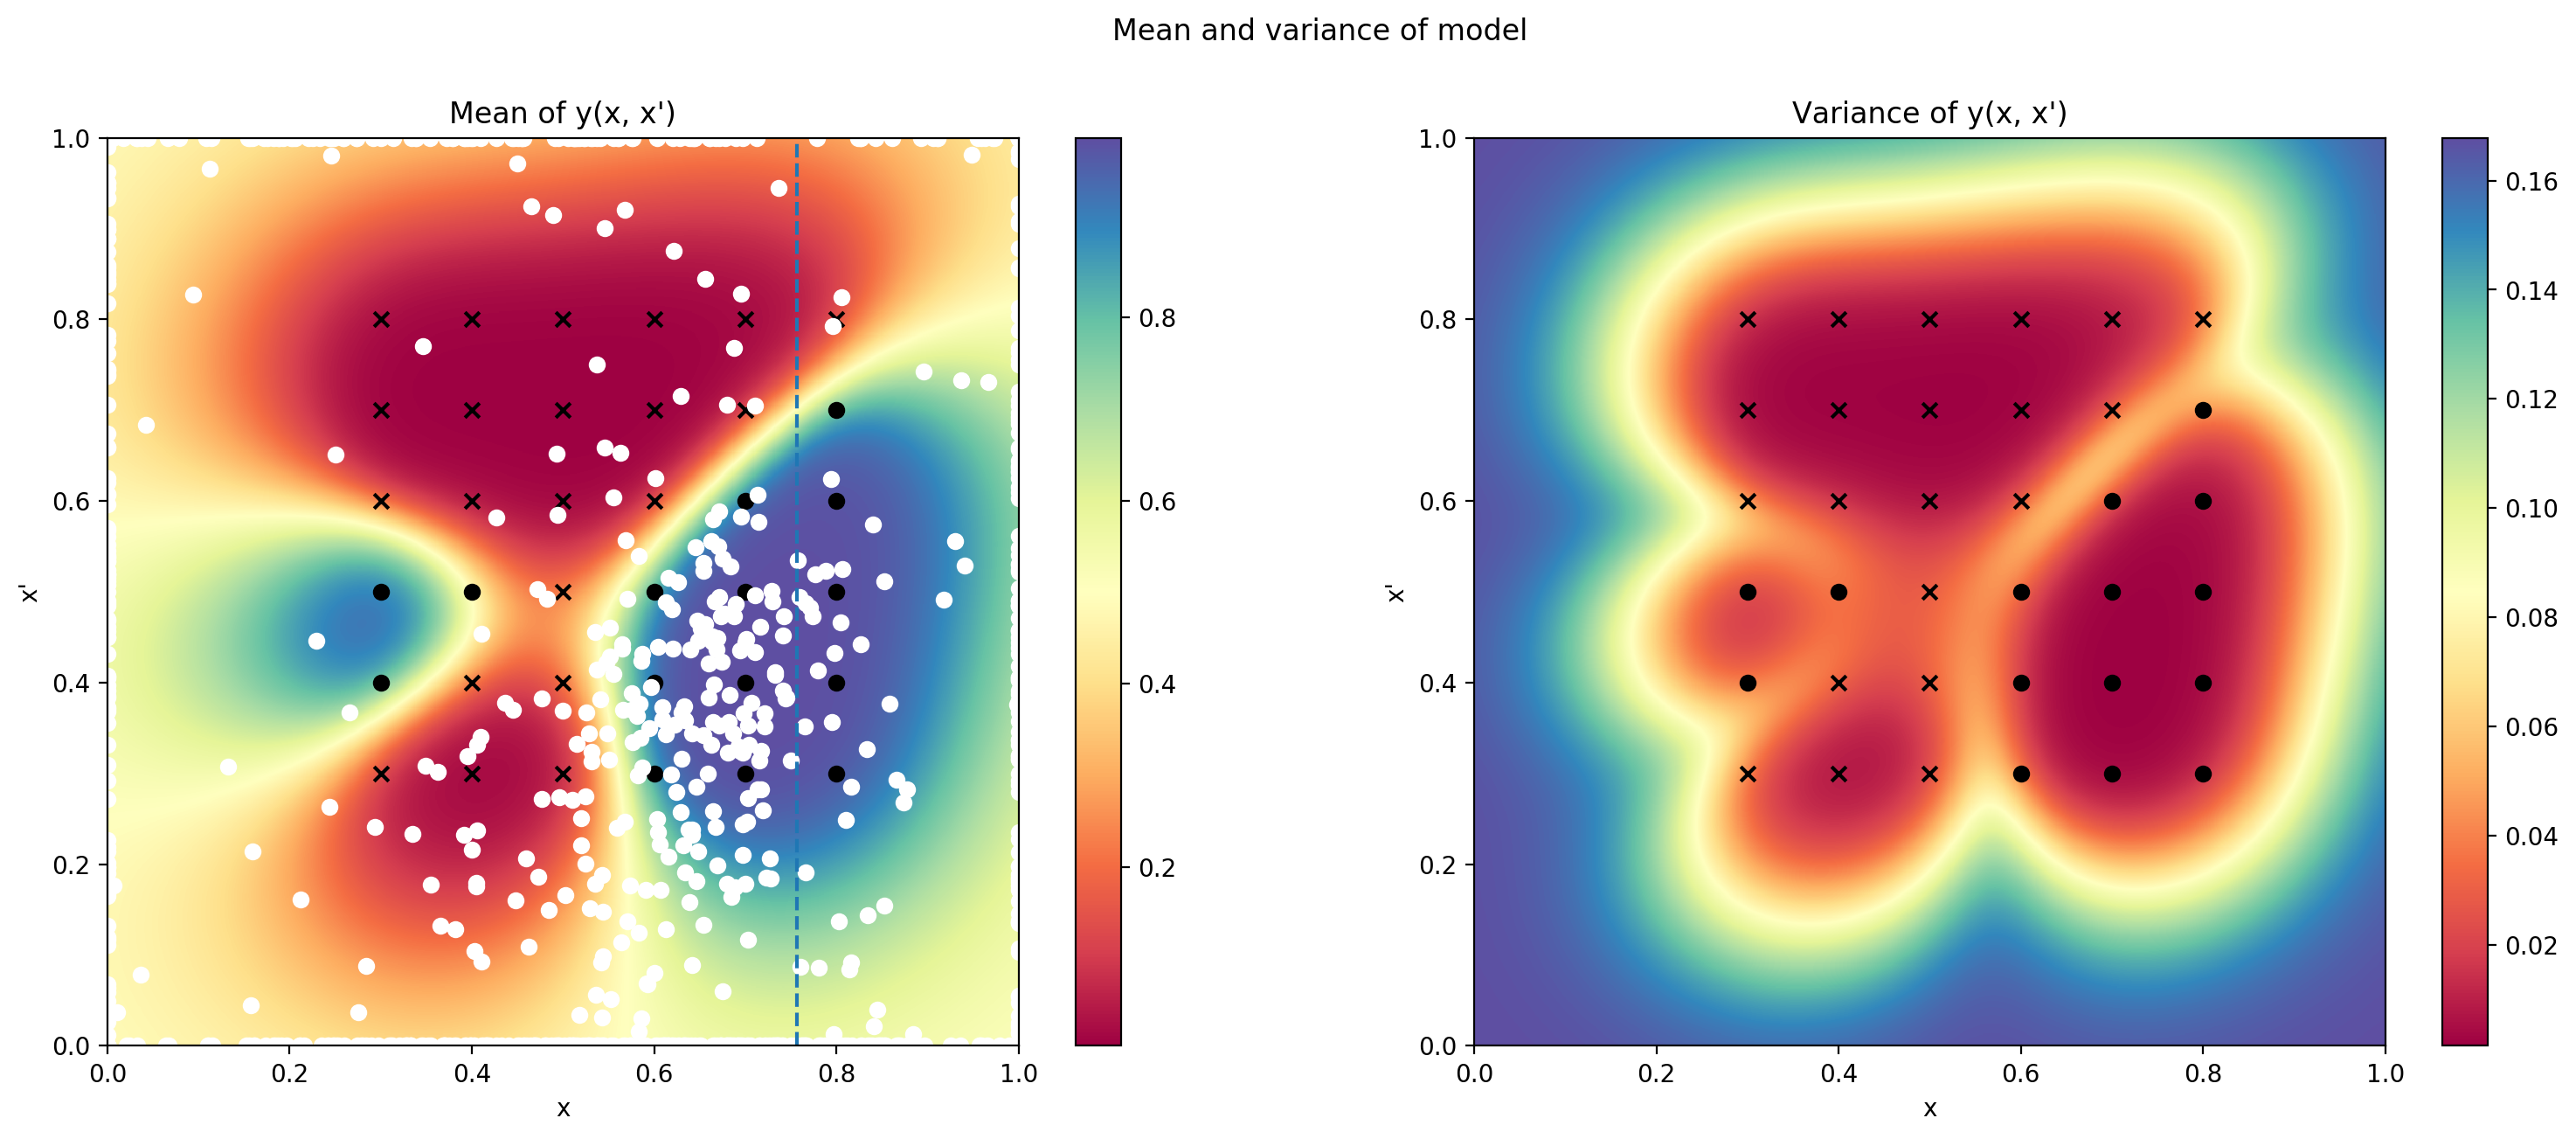

In [27]:
visualize_model(query_points, m, maximizers=maxs.numpy())

In [28]:
D = 100

In [29]:
testX = np.array([[[0.5, 0.7],
         [0.4, 0.7],
         [0.5, 0.5],
         [0.55, 0.5],
         [0.75, 0.5],
         [0.7, 0.4],
         [0.65, 0.38]]])

In [31]:
phi, W, b = PBO.acquisitions.pes.sample_fourier_features(testX, m.kernel)

In [32]:
WX_b = W @ tf.linalg.matrix_transpose(tf.expand_dims(query_points, axis=0)) + b  # (count, D, n)
alpha = m.kernel.variance
phi_y = tf.sqrt(2.0 * alpha / D) * tf.cos(tf.linalg.matrix_transpose(WX_b))

In [33]:
m.likelihood = gpflow.likelihoods.Gaussian()
theta = PBO.acquisitions.pes.sample_theta(phi_y, m, m.q_mu)

In [34]:
res = phi @ theta

In [35]:
for i in range(1000):
    phi, W, b = PBO.acquisitions.pes.sample_fourier_features(testX, m.kernel)
    phi_y = PBO.acquisitions.pes.fourier_features(tf.expand_dims(query_points, axis=0), W, b, m.kernel)
    
#     WX_b = W @ tf.linalg.matrix_transpose(tf.expand_dims(query_points, axis=0)) + b  # (count, D, n)
#     alpha = m.kernel.variance
#     phi_y = tf.sqrt(2.0 * alpha / D) * tf.cos(tf.linalg.matrix_transpose(WX_b))
    
    theta = PBO.acquisitions.pes.sample_theta(phi_y, m, m.q_mu)
    res = res + phi @ theta
res/1001

<tf.Tensor: shape=(1, 7, 1), dtype=float64, numpy=
array([[[-0.35391271],
        [-0.45025311],
        [-0.0996724 ],
        [-0.00263637],
        [ 0.22589974],
        [ 0.41052835],
        [ 0.42138058]]])>

In [ ]:
def soft_copeland(m, x):
    """"
    Average of the probability that x is the winner of a duel against all elements in x
    
    :param m: a gpflow model that predicts pi[x, x']
    :param x: a matrix of size n x d/2
    
    Returns a 1 x n matrix of means
    """   
    n = x.shape[0]
    d = x.shape[1]*2
    
    def combinations(points):
        n = points.shape[0]
        d = points.shape[1]

        out = np.zeros((n*n, d*2))
        for i in range(n):
            for j in range(n):
                out[i*n+j][0:d] = points[i]
                out[i*n+j][d:d*2] = points[j]
        return out

    combs = np.matrix(combinations(x))
    preds = m.predict_y(combs)
    means = np.zeros(n)
    for i in range(n):
        means[i] = np.mean(preds[0][i*n:(i+1)*n])
    return np.matrix(means)

In [ ]:
def sample_variances(m, x, x_other):
    x_tiled = np.tile(x, (x_other.shape[0], 1))
    x_xprime = np.bmat([x_tiled, x_other])
    return variance_logistic_f(m, x_xprime)

In [ ]:
def uniform_sample_func(input_dim, low=0.0, high=1.0):
    def func(num_points):
        return np.random.uniform(low, high, [num_points, input_dim])
    return func

def dueling_thompson_sampling(m, m_approx, sample_func, num_sample_points=500):
    """
    Dueling-Thompson sampling. Returns x and x' as the next input points to evaluate
    
    :param m: Trained model f
    :param m_approx: Sample model f
    :param sample_func: function that takes num_sample_points as a parameter
    :param num_sample_points: number of uniformly sampled points over input space to take the argmax over
    """
    
    #Step 1: selecting x    
    #Pick num_sample_points random points in input space using sample_func
    sample_points = sample_func(num_sample_points)
    means = soft_copeland(m_approx, sample_points)
    x_idx = np.argmax(means)
    x = sample_points[x_idx][0]
    log("Picked x with value " + str(x) + " and soft Copeland score " + str(means.item(x_idx)))
    
    # Remove x from sample_points so that we will not pick x' to be the same value
    sample_points[x_idx] = sample_points[0]
    
    #Step 2: selecting x'
    variances = sample_variances(m, x, sample_points).squeeze()
    var_idx = np.argmax(variances)
    x_prime = sample_points[var_idx][0]
    log("Picked x' with value " + str(x_prime) + " and variance " + str(variances.item(var_idx)))
    
    return np.matrix([x, x_prime])

In [ ]:
def forrester(x):
    """
    Simple one-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

In [ ]:
def forrester_get_y(pairs):
    """
    :param pairs: n x 2 matrix of input pairs [x, x'], x and x' are floats in [0, 1]
    
    Returns n x 1 matrix of y values indicating 1 if x wins the duel and 0 if x' wins the duel
    """
    n = pairs.shape[0]
    
    out = np.zeros([n, 1])
    for i in range(n):
        out[i][0] = int(forrester(pairs.item((i, 0))) <= forrester(pairs.item(i, 1)))
    
    return np.matrix(out)

In [ ]:
def PBO(X, Y, n, acquisition_func, winner_func):
    """
    Preferential Bayesian optimization algorithm (Algorithm 1) described in Preferential Bayesian Optimization by
    Gonzalez et al. (2017), to find Condorcet's winner
    
    :param X: matrix of size N x d. Training input points
    :param Y: matrix of size N x 1. Training target classifications
    :param acquisition_func: Function that returns next duel pair
    :param winner_func: Function that determines the winners of duel pairs
    """
    d = X.shape[1]
    
    for j in range(n):
        log("Starting iteration " + str(j))
        print(X)
        print(Y)
        
        #1. Fit a GP with kernel k to Dj and learn pi(x).
                
        # Train real f
        log("Training GP f")
        kern_rbf = gpflow.kernels.RBF(input_dim=d)
        kern_rbf.lengthscales.trainable = False
        kern_rbf.lengthscales = 0.1
        m = gpflow.models.VGP(X, Y, 
                               kern=kern_rbf, 
                               likelihood=gpflow.likelihoods.Bernoulli())
        gpflow.train.ScipyOptimizer().minimize(m)
        
        # Sample f using RFF
        log("Training RFF approximation GP of f")
        kern_rff = RFFApproximationKernel(input_dim=d) #Have to instantiate every time to obtain a different sample of f
        kern_rff.lengthscales.trainable = False
        kern_rff.lengthscales = 0.1
        m_approx = gpflow.models.VGP(X, Y, 
                               kern=kern_rff, 
                               likelihood=gpflow.likelihoods.Bernoulli())
        gpflow.train.ScipyOptimizer().minimize(m_approx)

        # 2 and 3. Compute the acquisition for duels alpha and get next duel
        log("Computing acquisition function")
        x_xprime_next = acquisition_func(m, m_approx, uniform_sample_func(1))
        log("x and x_prime: " + str(x_xprime_next))
        
        # 4. Run the duel and get y
        y_next = winner_func(x_xprime_next)
        log("y_next: " + str(y_next))
        
        # 5. Augment X and Y
        X = np.vstack([X, x_xprime_next])
        Y = np.vstack([Y, y_next])
    
    #Fit a GP with kernel k to Dn
    log("Training final GP")
    kern_rbf = gpflow.kernels.RBF(input_dim=d)
    kern_rbf.lengthscales.trainable = False
    kern_rbf.lengthscales = 0.1
    m_final = gpflow.models.VGP(X, Y, 
                                 kern=kern_rbf, 
                                 likelihood=gpflow.likelihoods.Bernoulli())
    gpflow.train.ScipyOptimizer().minimize(m_final)
    
    #Return current Condorcet's winner x*
    sample_points = uniform_sample_func(1)(1000)
    x_final = sample_points[np.argmax(soft_copeland(m_final, sample_points))][0]
    return X, Y, m_final, x_final

In [ ]:
Xtest = np.matrix([[0.1, 0.4],
                   [0.5, 0.2],
                   [0.8, 0.9],
                   [0.24, 0.7],
                   [0.6, 0.52]])
Ytest = forrester_get_y(Xtest)
X, Y, m_final, result = PBO(Xtest, Ytest, 30, dueling_thompson_sampling, forrester_get_y)